# 1. 환경 set-up
--> 거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.

## 1-1. 라이브러리 준비

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

## 1-2. 변수

In [2]:
AUTOTUNE= tf.data.experimental.AUTOTUNE
IMAGE_SIZE=[180,180]

ROOT_PATH= os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE=16
EPOCHS=25

print(ROOT_PATH)

/aiffel/aiffel


---

# 2. 데이터 준비

-신중한 augmentation 도입

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print("훈련용데이터: ",len(train_filenames))
print("시험용데이터: ", len(test_filenames))
print("검증용데어터: ",len(val_filenames))

훈련용데이터:  5216
시험용데이터:  624
검증용데어터:  16


### ▶ 훈련용데이터 일부를 검증용 데이터로 보내어 dataset의 비를 8:2(시험:검증)변경

In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print("시험용데이터:",len(train_filenames))
print("검증용데어터:",len(val_filenames))

시험용데이터: 4185
검증용데어터: 1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0423-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"훈련 데이터셋의 갯수: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"폐렴 데이터샛의 갯수: {COUNT_PNEUMONIA}")

print(f"폐렴 데이터샛의 갯수: int({COUNT_PNEUMONIA})-int({COUNT_NORMAL})")

훈련 데이터셋의 갯수: 1082
폐렴 데이터샛의 갯수: 3103
폐렴 데이터샛의 갯수: int(3103)-int(1082)


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"훈련이미지 수: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"검증이미지 수: {VAL_IMG_COUNT}")

훈련이미지 수: 4185
검증이미지 수: 1047


## 이미지의 label이 없이므로 추가하도록 하자

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

process_path 함수에서 decode_img 함수를 이용  
이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경

In [10]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

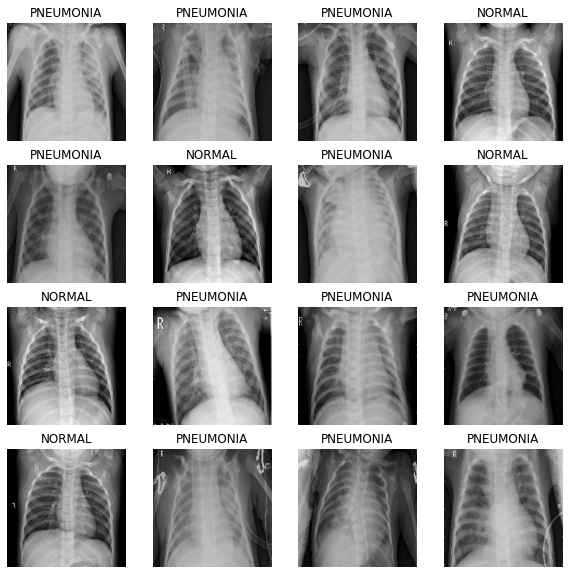

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 3. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 4. Imbalancing of datasets

- traingset중에서 폐렴 음성보다 양성 이미지가 훨씬 많으므로 결코 좋은 학습조건이 아니다.
- Weight balacning 도입

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for 폐렴 음성: {:.2f}'.format(weight_for_0))
print('Weight for 폐렴 양성: {:.2f}'.format(weight_for_1))

Weight for 폐렴 음성: 1.93
Weight for 폐렴 양성: 0.67


# 5. 훈련개시

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 63s 190ms/step - loss: 0.3675 - accuracy: 0.8278 - precision: 0.9559 - recall: 0.8049 - val_loss: 0.6556 - val_accuracy: 0.7462 - val_precision: 0.7462 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2305 - accuracy: 0.9155 - precision: 0.9744 - recall: 0.9100 - val_loss: 1.3172 - val_accuracy: 0.7481 - val_precision: 0.7481 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 50s 193ms/step - loss: 0.2028 - accuracy: 0.9203 - precision: 0.9755 - recall: 0.9152 - val_loss: 0.2054 - val_accuracy: 0.9067 - val_precision: 0.8888 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1684 - accuracy: 0.9334 - precision: 0.9806 - recall: 0.9287 - val_loss: 0.0787 - val_accuracy: 0.9779 - val_precision: 0.9934 - val_recall: 0.9768
Epoch 5/25
261/261 [==============================] - 52s 200ms/step - loss: 0.1794 - accura

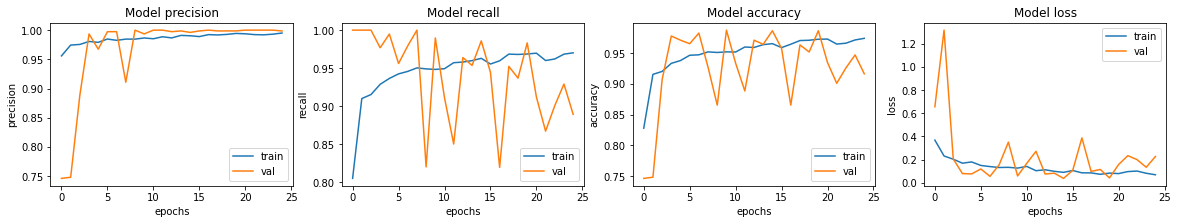

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.6611 - accuracy: 0.8574 - precision: 0.8508 - recall: 0.9359
Loss: 0.6610607504844666,
Accuracy: 0.8573718070983887,
Precision: 0.8508158326148987,
Recall: 0.9358974099159241


### LMS 학습 방식의 모델 
#### 정확도는 85%이고  Loss는 감소추세가 보여서 epoch를 조금만 더 많이하면 성능이 더 높으리라 예상되지만 목표 정확도나 나왔으나 개념적으로 아주 우수한 성능 보장한다는 Batch normalization의 효과를 확인하기 위해 이를 제거하고 learning 해보기로 하였다.

# 6. 모델변경

## Batch normalization 제거

In [24]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
#       tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [25]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
#        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [26]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [27]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 55s 181ms/step - loss: 0.6943 - accuracy: 0.5230 - precision: 0.7349 - recall: 0.5578 - val_loss: 0.6988 - val_accuracy: 0.2529 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
261/261 [==============================] - 47s 181ms/step - loss: 0.6939 - accuracy: 0.4315 - precision: 0.7349 - recall: 0.3645 - val_loss: 0.6980 - val_accuracy: 0.2548 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
261/261 [==============================] - 47s 180ms/step - loss: 0.6929 - accuracy: 0.4921 - precision: 0.7396 - recall: 0.4874 - val_loss: 0.6922 - val_accuracy: 0.7442 - val_precision: 0.7442 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 47s 182ms/step - loss: 0.6933 - accuracy: 0.4763 - precision: 0.7465 - recall: 0.4449 - val_loss: 0.6898 - val_accuracy: 0.7433 - val_precision: 0.7433 - val_recall: 1.0000
Epoch 5/25
261/261 [==============================] - 49s 187ms/step - loss:

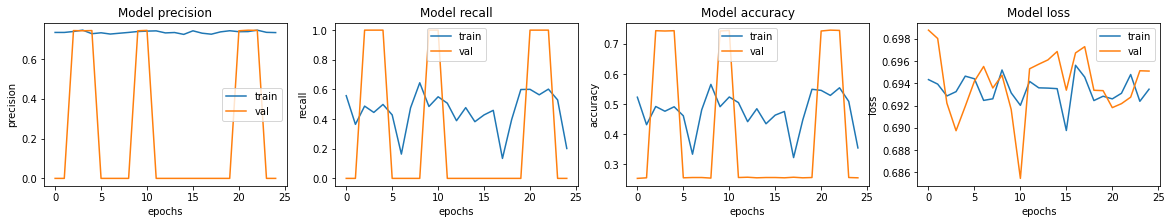

In [29]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# 7. 퇴고

▶ 최초로 시도 하였을때 accuracy가 84였으나 85까지 가능성이 보여서 재시도하여 85까지 가능하였다.  
▶ Batch normalization을 제거하여 local optimum에 빠지는 문제는 보여지지 않으나 Internal Covariance Shift로 인해 accuracy가 상당히 요동치는것으로 생각된다.   
▶ optimizer는 거의 무조건적으로 adam을 쓰므로 이것의 빠른 accuracy도달에 관해서도 확인해볼 필요는 있을 것 같다.   
▶ dropout이 Batch normalization과 동일한 효능을 발휘한다고 하였지만 여기서는 그러지 못한 것으로 보아 batch normalization의 효용성이 더 높은 것으로 생각된다.